# Analysis for WM_NoiseV11
- (1) data quality and subject check
- (2) explore differences between subjects who passed/failed quality checks 
- (3) circular statistics
- (4) Bayes repeated measures ANOVA
### HKular 11.7.23

# Import libraries and load data, some data wrangling

In [1]:
## Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
from IPython.display import display

# Get the user's login name
login_name = os.environ.get('USER', os.environ.get('USERNAME'))
# Set the working directory
directory_path = f'/Users/{login_name}/Documents/Github/noisefx/Starburst_V11'
os.chdir(directory_path)

# Load data
V11 = pd.read_csv('WM_noiseV11.csv') # good subjects
V11b = pd.read_csv('WM_noiseV11_bad.csv') # bad subjects to compare

# Make numerical values that are factors actually factors
factor_mapping = {
    'distractor': {1: 'none', 2: 'ignore', 3: 'attend'},
    'kappa': {100: 'high', 5000: 'low'},
    'change': {10: 'ccw', -10: 'cw'},
    'dist': {114: 'ccw', 112: 'ccw', 117: 'cw', 115: 'cw'}
}

V11.replace(factor_mapping, inplace=True)
V11b.replace(factor_mapping, inplace=True)


# (1) Individual subject quality check

In [2]:
## If they withdraw from the experiment before completing all trials (n = 576)
ntrials = V11['subject'].value_counts()
# V11 = V11[~V11['subject'].isin(insert attrition here)]

# Responded to at least 90% of the distractors in the attend-distractor condition
attendrespcheck = V11[V11['distractor'] == 'attend'].groupby('subject')['dist'].count()
attendrespcheck = attendrespcheck[attendrespcheck.isna()]
for subject, count in attendrespcheck.items():
    if count > 0.1 * ntrials[subject] / 3:
        print(f"exclude subject {subject} no response to attend")
  

In [3]:
# Responded to more than 10% of the distractors in the ignore-distractor condition
ignorerespcheck = V11[V11['distractor'] == 'ignore'].groupby('subject')['dist'].count()
ignorerespcheck = ignorerespcheck[ignorerespcheck.isna()]
for subject, count in ignorerespcheck.items():
    if count < 0.9 * ntrials[subject] / 3:
        print(f"exclude subject {subject} response to ignore")


In [4]:
# Responded to at least 90% of the targets
nonrespcheck = V11.groupby('subject')['resp'].count()
nonrespcheck = nonrespcheck[nonrespcheck.isna()]
for subject, count in nonrespcheck.items():
    if count > 0.1 * ntrials[subject]:
        print(f"exclude subject {subject} no response to target")


In [6]:
# Subjects will be removed if there is evidence for responses clustered around the orientation of the distractor
# Instead of around the memory target, a cluster of responses around the distractor orientation suggests non-compliance with task instructions.
# Filter data
taskcheck = V11.dropna(subset=['distractorori', 'resp'])

# Set the figure style
plt.figure(figsize=(18, 4))
sns.set(style="whitegrid")


# Create scatter plot with facets
g = sns.FacetGrid(taskcheck, col="subject", col_wrap= 6, height=6)
g.map_dataframe(plt.scatter, "distractorori", "resp", alpha=.7, s=10)

# Set x-axis labels and tick marks
g.set(xticks=[0, 45, 90, 135, 180], xticklabels=["0°", "45°", "90°", "135°", "180°"], xlim=(0, 180))

# Set y-axis labels and tick marks
g.set(yticks=[20, 40, 60, 80, 100, 120, 140, 160], yticklabels=["20°", "40°", "60°", "80°", "100°", "120°", "140°", "160°"], ylim=(0, 180))

# Add x-axis and y-axis titles
g.set_axis_labels("Distractor (degrees)", "Response (degrees)")

# Optionally display the plot
#display(plt.gcf())

# Optionally save the plot to a file
# plt.savefig("scatter_plot.png")

# Optionally close the plot window
plt.close()

<Figure size 1296x288 with 0 Axes>

In [2]:
# Is the average measured performance error is greater than 49 degrees
from scipy.stats import circmean
from scipy.stats import circstd
perfcheck = V11.groupby('subject').agg(
    circ_mean=('acc', lambda x: circmean(x * np.pi / 180)),
    circ_std=('acc', lambda x: circstd(x * np.pi / 180))
)
perfcheck = perfcheck[perfcheck['circ_std'] * 180 / np.pi > 49]
for subject in perfcheck.index:
    print(f"exclude subject {subject} large behavior error")
       

# (2) Pass/fail comparison
- reaction times
- timing of missed responses
- response accuracies for distractor response

In [7]:
# check RTs
from scipy.stats import ttest_ind

# Check RTs for target
targRT = V11.dropna(subset=['resp']).groupby('subject')['targRT'].agg(['mean', 'std']).reset_index()
targRTavg = targRT['mean'].mean()
targRTb = V11b.dropna(subset=['resp']).groupby('subject')['targRT'].agg(['mean', 'std']).reset_index()
targRTavgb = targRTb['mean'].mean()

# Check RTs for distractor response
distRT = V11.dropna(subset=['resp']).groupby('subject')['distRT'].agg(['mean', 'std']).reset_index()
distRTavg = distRT['mean'].mean()
distRTb = V11b.dropna(subset=['resp']).groupby('subject')['distRT'].agg(['mean', 'std']).reset_index()

distRTavgb = distRTb['mean'].mean()

# Compare with two-sample t-test
distRTtest_results = ttest_ind(distRT['mean'], distRTb['mean'], equal_var=False)
targRTtest_results = ttest_ind(targRT['mean'], targRTb['mean'], equal_var=False)


In [9]:
# Look at when misses were, early? later blocks? middle blocks?
# Filter (attend trials) plot block and counts
V11b['trial'] = V11b.groupby('subject').cumcount() + 1
V11b['block'] = np.tile(np.repeat(np.arange(1, 25), 24), len(V11b) // (24*24))

nan_count = V11b[V11b['distractorname'] == 'attend'].groupby('block')['distRT'].apply(lambda x: sum(x.isna())).reset_index()

sns.lineplot(x='block', y='distRT', data=nan_count)
plt.xlabel("Block Number")
plt.ylabel("NaN Count")
plt.title("No response to attend V11b")
#plt.show()

# Look at when good subs miss attend response
V11['block'] = np.tile(np.repeat(np.arange(1, 25), 24), len(V11) // (24*24))# 24 is number of blocks in the experiment

nan_count_g = V11[V11['distractorname'] == 'attend'].groupby('block')['distRT'].apply(lambda x: sum(x.isna())).reset_index()

sns.lineplot(x='block', y='distRT', data=nan_count_g)
plt.xlabel("Block Number")
plt.ylabel("NaN Count")
plt.title("No response to attend V11")
#plt.show()

# Optionally close the plot window
plt.close()

In [10]:
# compare the distractor response accuracies across good and bad subjects
dist_accb = (
    V11b[V11b['distractorname'] != 'none']
    .dropna(subset=['distRT', 'dist', 'change'])
    .groupby('subject')
    .apply(lambda group: pd.Series({
        'count': (group['dist'] == group['change']).sum(),
        'total': group['change'].count()
    }))
)


dist_acc = V11[V11['distractorname'] != 'none'].dropna(subset=['distRT']).groupby('subject').apply(lambda group: pd.Series({
        'count': (group['dist'] == group['change']).sum(),
        'total': group['change'].count()
    }))

dist_acc['group'] = 'Good'
dist_accb['group'] = 'Bad'

# Concatenate the DataFrames
plot_data = pd.concat([dist_acc, dist_accb])
plot_data['count/total'] = plot_data['count'] / plot_data['total']

# Plot distractor accuracy against chance
sns.boxplot(x='group', y='count/total', data=plot_data, palette=['lightblue', 'pink'])
sns.swarmplot(x='group', y='count/total', data=plot_data, color='blue', marker='o', alpha=0.7)

# Add the horizontal dashed line and label
plt.axhline(0.5, linestyle='--', color='purple')
plt.text(1.5, 0.5, 'chance', va='center', ha='left', color='purple')

# Set labels and title
plt.xlabel("Subjects")
plt.ylabel("Accuracy")
plt.title("Distractor response accuracy")

#plt.show()
plt.close()

# (3) Circular statistics

In [3]:
def circ_vector(x):
    return np.mean(np.exp(x*1j)) 
def circ_mean(x): # assumes full circle in radians
    return np.angle(circ_vector(x))
def circ_sd(x): # assumes full circle in radians
    unit_vectors = np.array([np.cos(x), np.sin(x)])
    angles = (np.arctan2(unit_vectors[1], unit_vectors[0]))
    return np.std(angles)

In [4]:
# Calculate circstats
V11 = V11.dropna(subset=['resp'])# filter out NaNs
V11['acc_rad'] = np.radians(V11['acc'])
dfV11_circstats = V11.groupby(['subject', 'kappa', 'distractor']).agg(
    circ_mean=('acc_rad', lambda x: circ_mean(x)),
    circ_sd=('acc_rad', lambda x: circ_sd(x)),
).reset_index()


dfV11_circstats['subject'] = dfV11_circstats['subject'].astype('category')
dfV11_circstats['kappa'] = dfV11_circstats['kappa'].astype('category')
dfV11_circstats['distractor'] = dfV11_circstats['distractor'].astype('category')

n_subj = len(dfV11_circstats['subject'].unique())


# Calculate summary statistics for plotting
dfV11_circstats_plt = dfV11_circstats.groupby(['kappa', 'distractor']).agg(
    mean_sd=('circ_sd', 'mean'),
    sd_sd=('circ_sd', 'std'),
    se_sd=('circ_sd', lambda x: np.std(x) / np.sqrt(n_subj)),
).reset_index()

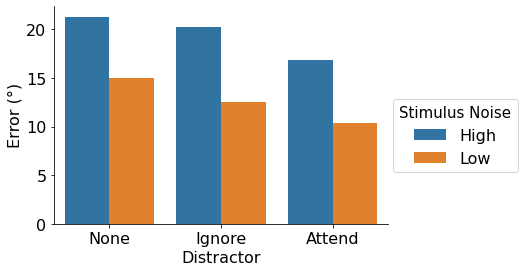

In [5]:
dfV11_circstats_plt['mean_sd_deg'] = dfV11_circstats_plt['mean_sd'] * 180/np.pi
ax = sns.barplot(x = 'distractor', y = 'mean_sd_deg', hue = 'kappa', data = dfV11_circstats_plt)
ax.set_ylabel("Error (°)", fontsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xlabel("Distractor", fontsize=16)
ax.set_xticklabels(['None', 'Ignore', 'Attend'], fontsize=16)
labels = ['High', 'Low']
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, title="Stimulus Noise", title_fontsize = 15, fontsize = 16, loc = 'lower center', bbox_to_anchor=(1.2, .2))
sns.despine(top = True)

# (4) Bayes repeated measures anova in R
 based on Rouder et al. 2012

In [2]:
from rpy2.robjects import pandas2ri
r_dataframe = pandas2ri.py2ri(dfV11_circstats)


Unable to determine R library path: Command '('/Users/hkular/opt/anaconda3/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' died with <Signals.SIGABRT: 6>.


OSError: cannot load library '/Users/hkular/opt/anaconda3/lib/R/lib/libR.dylib': dlopen(/Users/hkular/opt/anaconda3/lib/R/lib/libR.dylib, 0x0002): Library not loaded: @rpath/libreadline.6.2.dylib
  Referenced from: <185433D7-8B40-31AA-8BD9-465D23C57257> /Users/hkular/opt/anaconda3/lib/R/lib/libR.dylib
  Reason: tried: '/Users/hkular/opt/anaconda3/lib/R/lib/../../libreadline.6.2.dylib' (no such file), '/Users/hkular/opt/anaconda3/lib/R/lib/../../libreadline.6.2.dylib' (no such file), '/Users/hkular/opt/anaconda3/lib/libreadline.6.2.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/hkular/opt/anaconda3/lib/libreadline.6.2.dylib' (no such file), '/Users/hkular/opt/anaconda3/lib/libreadline.6.2.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/hkular/opt/anaconda3/lib/libreadline.6.2.dylib' (no such file), '/Users/hkular/opt/anaconda3/lib/python3.8/site-packages/../../libreadline.6.2.dylib' (no such file), '/Users/hkular/opt/anaconda3/lib/libreadline.6.2.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/hkular/opt/anaconda3/lib/libreadline.6.2.dylib' (no such file), '/Users/hkular/opt/anaconda3/bin/../lib/libreadline.6.2.dylib' (no such file), '/usr/local/lib/libreadline.6.2.dylib' (no such file), '/usr/lib/libreadline.6.2.dylib' (no such file, not in dyld cache)

In [ ]:

base = importr('base')
BF = importr('BayesFactor')

r_command = """
BFrmV11 <- anovaBF(circ_sd ~ kappa + distractor + kappa:distractor + id,
                   data = dfV11_circstats, whichRandom = "id", whichModels = 'all')
"""

# Execute the R command
base.eval(r_command)

NameError: name 'R_HOME' is not defined

In [ ]:
# switch to R kernel
(BFrmV11 <- anovaBF(circ_sd ~ kappa + distractor + kappa:distractor + id,
data = dfV11_circstats, whichRandom = "id", whichModels = 'all') )# Bayesian mixed effects ANOVA
BFrmV11[7]/BFrmV11[4] # evidence of interaction with main effects accounted for


#(5) Distractor bias

In [ ]:
# switch back to python kernel